### `01: It's a flow of tensors`

If you have already built a model, you can use the model.layers and the tensorflow.keras.backend to build functions that, provided with a valid input tensor, return the corresponding output tensor.

This is a useful tool when we want to obtain the output of a network at an intermediate layer.

For instance, if you get the input and output from the first layer of a network, you can build an inp_to_out function that returns the result of carrying out forward propagation through only the first layer for a given input tensor.

So that's what you're going to do right now!

X_test from the Banknote Authentication dataset and its model are preloaded. Type model.summary() in the console to check it.

- Import `tensorflow.keras.backend` as `K`.
- Use the `model.layers` list to get a reference to the input and output of the first layer.
- Use `K.function()` to define a function that maps `inp` to `out`.
- Print the results of passing `X_test` through the 1st layer.

In [1]:
import numpy as np 
import pandas as pd 
# Import the sequential model and dense layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

X_test = np.load("datasets/X_test.npy")
X_test.shape

(412, 4)

In [2]:
model = Sequential()
model.add(Dense(2, activation='relu', input_shape=(4,)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 10        
                                                                 
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


In [3]:
# Import tensorflow.keras backend
import tensorflow.keras.backend as K

# Input tensor from the 1st layer of the model
inp = model.layers[0].input

# Output tensor from the 1st layer of the model
out = model.layers[0].output

# Define a function from inputs to outputs
inp_to_out = K.function([inp], [out])

# Print the results of passing X_test through the 1st layer
print(inp_to_out([X_test]))

[array([[0.        , 0.        ],
       [1.2390989 , 1.5125483 ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [1.4250642 , 0.        ],
       [2.523396  , 1.1728524 ],
       [0.35624328, 0.04711603],
       [2.4128842 , 1.3025869 ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.4241574 , 0.        ],
       [0.        , 0.        ],
       [1.0310661 , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.3910708 ],
       [0.        , 0.        ],
       [0.31576145, 0.        ],
       [1.9684714 , 1.1588181 ],
       [2.9468443 , 1.6315516 ],
       [0.        , 0.        ],
       [1.0882361 , 0.36346614],
       [0.01760545, 1.1123173 ],
       [0.2024549 , 0.75791305],
       [0.1007497 , 0.12038083],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.15007691, 0.        ],
       [1.2337707 , 1.0609541 ],
       [0

Nice job! Let's use this function for something more interesting.



### `02: Neural separation`
Put on your gloves because you're going to perform brain surgery!

Neurons learn by updating their weights to output values that help them better distinguish between the different output classes in your dataset. You will make use of the inp_to_out() function you just built to visualize the output of two neurons in the first layer of the Banknote Authentication model as it learns.

The model you built in chapter 2 is ready for you to use, just like X_test and y_test. Paste show_code(plot) in the console if you want to check plot().

You're performing heavy duty, once all is done, click through the graphs to watch the separation live!

- Use the previously defined `inp_to_out()` function to get the outputs of the first layer when fed with X_test.
- Use the `model.evaluate()` method to obtain the validation accuracy for the test dataset at each epoch.

In [4]:
X_train = np.load("datasets/X_train_week2.npy")
y_train = np.load("datasets/y_train_week2.npy")
X_test = np.load("datasets/X_test_week2.npy")
y_test = np.load("datasets/y_test_week2.npy")

In [5]:
import matplotlib.pyplot as plt 
def plot():
  fig, ax = plt.subplots()
  plt.scatter(layer_output[:, 0], layer_output[:, 1],c = y_test,edgecolors='none')
  plt.title('Epoch: {}, Test Accuracy: {:3.1f} %'.format(i+1, test_accuracy * 100.0))
  plt.show()

30/30 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.8396


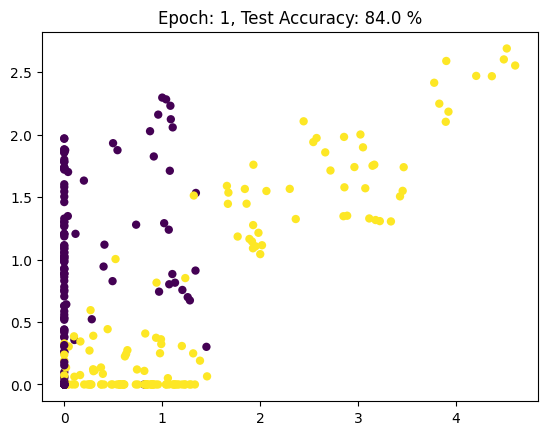

30/30 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.8021


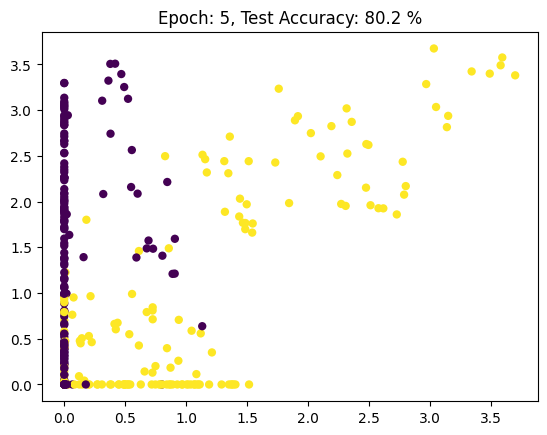

30/30 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.6344


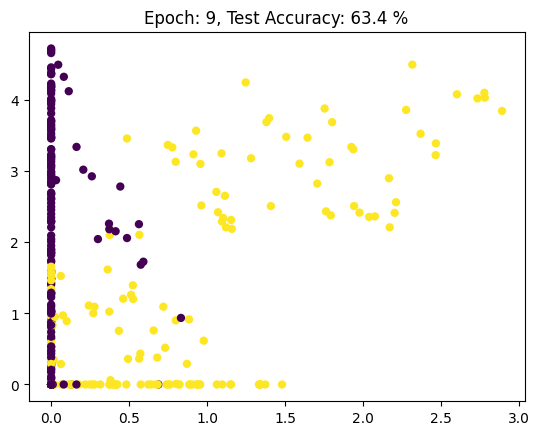

30/30 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.6021


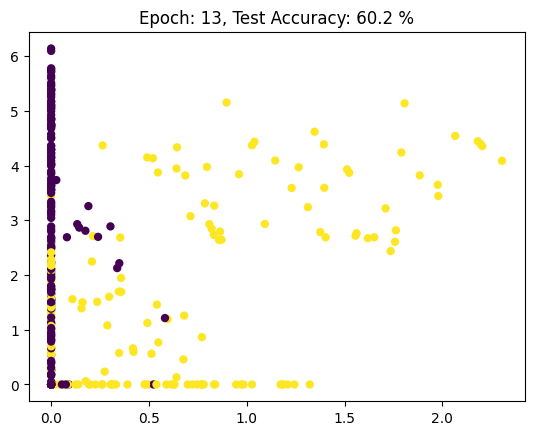

30/30 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.5667


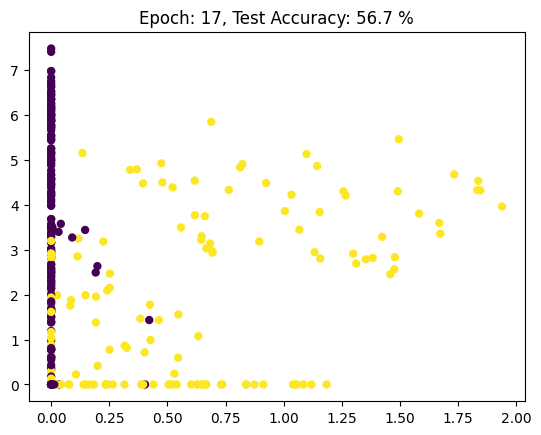

30/30 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.5594


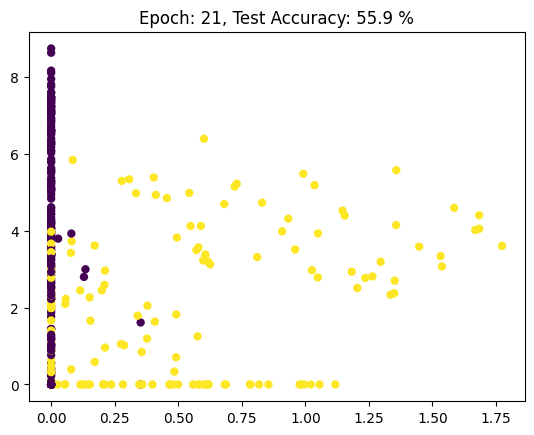

In [6]:
for i in range(0, 21):
  	# Train model for 1 epoch
    h = model.fit(X_train, y_train, batch_size = 16, epochs = 1, verbose = 0)
    if i%4==0: 
      # Get the output of the first layer
      layer_output = inp_to_out([X_test])[0]
      
      # Evaluate model accuracy for this epoch
      test_accuracy = model.evaluate(X_train, y_train)[1] 
      
      # Plot 1st vs 2nd neuron output
      plot()

That took a while! If you take a look at the graphs you can see how the neurons are learning to spread out the inputs based on whether they are fake or legit dollar bills. (A single fake dollar bill is represented as a purple dot in the graph) At the start the outputs are closer to each other, the weights are learned as epochs go by so that fake and legit dollar bills get a different, further and further apart output. Click in between the graphs fast, it's like a movie!



### `03: Building an autoencoder`
Autoencoders have several interesting applications like anomaly detection or image denoising. They aim at producing an output identical to its inputs. The input will be compressed into a lower dimensional space, encoded. The model then learns to decode it back to its original form.

You will encode and decode the MNIST dataset of handwritten digits, the hidden layer will encode a 32-dimensional representation of the image, which originally consists of 784 pixels (28 x 28). The autoencoder will essentially learn to turn the 784 pixels original image into a compressed 32 pixels image and learn how to use that encoded representation to bring back the original 784 pixels image.

The Sequential model and Dense layers are ready for you to use.

Let's build an autoencoder!

- Create a `Sequential` model.
- Add a dense layer with as many neurons as the encoded image dimensions and `input_shape` the number of pixels in the original image.
- Add a final layer with as many neurons as pixels in the input image.
- Compile your `autoencoder` using `adadelta` as an optimizer and `binary_crossentropy` loss, then summarise it.

In [7]:
# Start with a sequential model
autoencoder = Sequential()

# Add a dense layer with input the original image pixels and neurons the encoded representation
autoencoder.add(Dense(32, input_shape=(784 , ), activation="relu"))

# Add an output layer with as many neurons as the orginal image pixels
autoencoder.add(Dense(784, activation = "sigmoid"))

# Compile your model with adadelta
autoencoder.compile(optimizer = 'adadelta', loss = 'binary_crossentropy')

# Summarize your model structure
autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 32)                25120     
                                                                 
 dense_3 (Dense)             (None, 784)               25872     
                                                                 
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


Great start! Your autoencoder is now ready. Let's see what you can do with it!



### `04: De-noising like an autoencoder`
Okay, you have just built an autoencoder model. Let's see how it handles a more challenging task.

First, you will build a model that encodes images, and you will check how different digits are represented with show_encodings(). To build the encoder you will make use of your autoencoder, that has already being trained. You will just use the first half of the network, which contains the input and the bottleneck output. That way, you will obtain a 32 number output which represents the encoded version of the input image.

Then, you will apply your autoencoder to noisy images from MNIST, it should be able to clean the noisy artifacts.

X_test_noise is loaded in your workspace. The digits in this noisy dataset look like this:
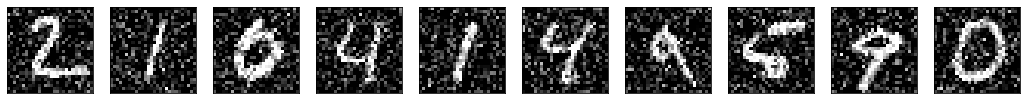

Apply the power of the autoencoder!

- Build an `encoder` model with the first layer of your trained `autoencoder` model.
- Predict on `X_test_noise` with your `encoder` and show the results with `show_encodings()`.


In [8]:
X_test_noise = np.load('datasets/X_test_noise.npy')
y_test = np.array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6,
       6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2,
       3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4,
       6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3,
       6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9])

In [9]:
def show_encodings(encoded_imgs,number=1):
    n = 5  # how many digits we will display
    original = X_test_noise
    original = original[np.where(y_test == number)]
    encoded_imgs = encoded_imgs[np.where(y_test==number)]
    plt.figure(figsize=(20, 4))
    #plt.title('Original '+str(number)+' vs Encoded representation')
    for i in range(min(n,len(original))):
        # display original imgs
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display encoded imgs
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(np.tile(encoded_imgs[i],(32,1)))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

4/4 [==============================] - 0s 1ms/step


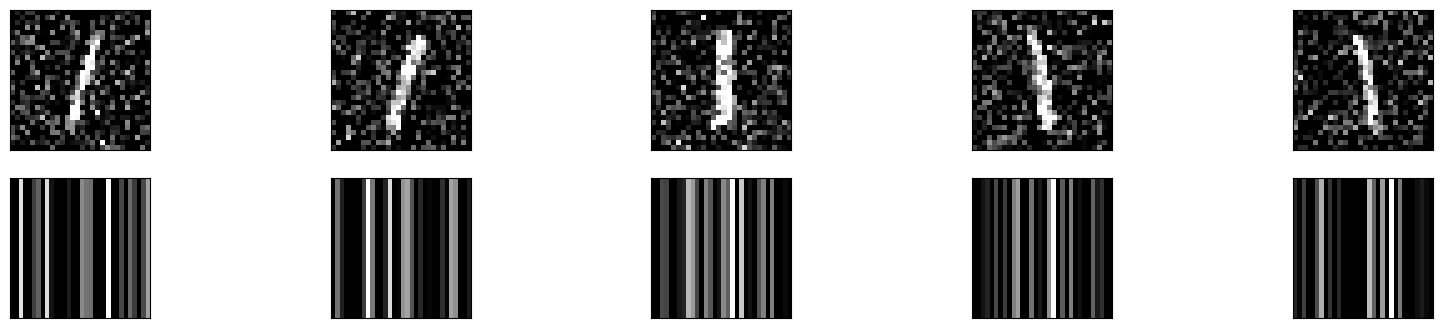

In [10]:
# Build your encoder by using the first layer of your autoencoder
encoder = Sequential()
encoder.add(autoencoder.layers[0])

# Encode the noisy images and show the encodings for your favorite number [0-9]
encodings = encoder.predict(X_test_noise)
show_encodings(encodings, number = 1)

- Predict on X_test_noise with your autoencoder, this will effectively perform both the encoding and decoding.
- Plot noisy vs decoded images with compare_plot().

In [11]:
def compare_plot(original,decoded_imgs):
    n = 4  # How many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.title('Noisy vs Decoded images')
    plt.show()

4/4 [==============================] - 0s 1ms/step


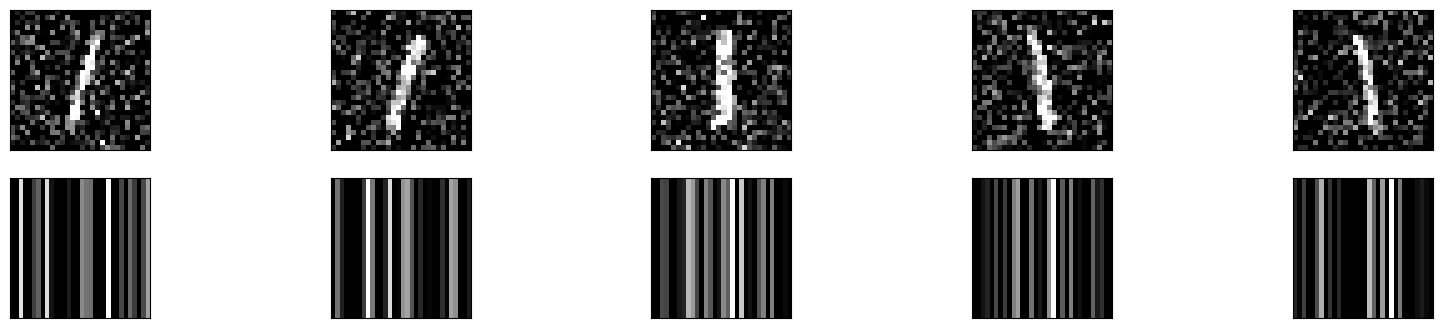

4/4 [==============================] - 0s 1ms/step


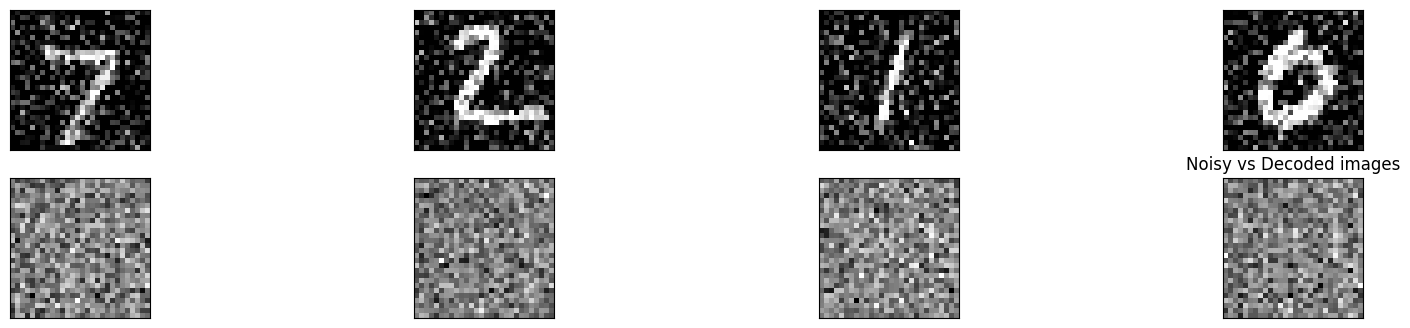

In [12]:
# Build your encoder by using the first layer of your autoencoder
encoder = Sequential()
encoder.add(autoencoder.layers[0])

# Encode the noisy images and show the encodings for your favorite number [0-9]
encodings = encoder.predict(X_test_noise)
show_encodings(encodings, number = 1)

# Predict on the noisy images with your autoencoder
decoded_imgs = autoencoder.predict(X_test_noise)

# Plot noisy vs decoded images
compare_plot(X_test_noise, decoded_imgs)

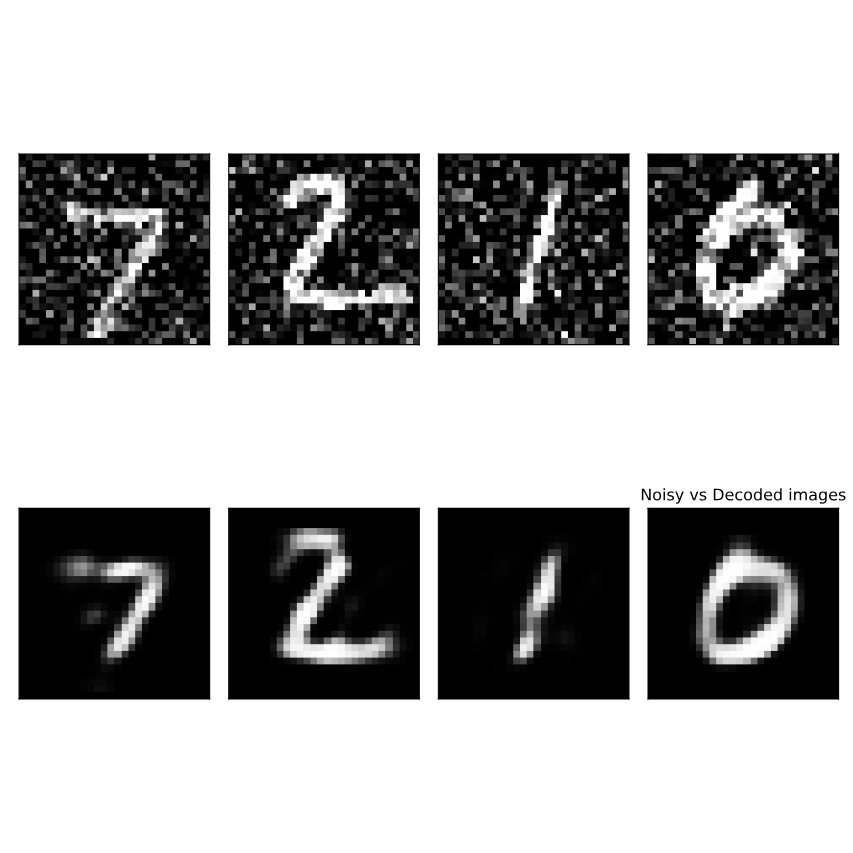

Amazing! The noise is gone now! You could get a better reconstruction by using a convolutional autoencoder. I hope this new model opened up your mind to the many possible architectures and non-classical ML problems that neural networks can solve :)



### `05: Building a CNN model`
Building a CNN model in Keras isn't much more difficult than building any of the models you've already built throughout the course! You just need to make use of convolutional layers.

You're going to build a shallow convolutional model that classifies the MNIST digits dataset. The same one you de-noised with your autoencoder! The images are 28 x 28 pixels and just have one channel, since they are black and white pictures.

Go ahead and build this small convolutional model!

- Import the `Conv2D` and `Flatten` layers and instantiate your model.
- Add a first convolutional layer with 32 filters of size 3x3 and the corresponding 3D tuple as `input_shape`.
- Add a second convolutional layer with 16 filters of size 3x3 with relu activation.
- Flatten the previous layer output to create a one-dimensional vector.

In [13]:
# Import the Conv2D and Flatten layers and instantiate model
from tensorflow.keras.layers import Conv2D,Flatten
model = Sequential()

# Add a convolutional layer of 32 filters of size 3x3
model.add(Conv2D(32, kernel_size = 3, input_shape = (28, 28, 1), activation = 'relu'))

# Add a convolutional layer of 16 filters of size 3x3
model.add(Conv2D(16, kernel_size = 3, activation = 'relu'))

# Flatten the previous layer output
model.add(Flatten())

# Add as many outputs as classes with softmax activation
model.add(Dense(10, activation = 'softmax'))

Well done! You can see that the key concepts are the same, you just have to use new layers!



### `06: Looking at convolutions`
Inspecting the activations of a convolutional layer is a cool thing. You have to do it at least once in your lifetime!

To do so, you will build a new model with the Keras Model object, which takes in a list of inputs and a list of outputs. The outputs you will provide to this new model is the first convolutional layer outputs when given an MNIST digit as input image.

The convolutional model you built in the previous exercise has already been trained for you. It can now correctly classify MNIST handwritten images. You can check it with model.summary() in the console.

Let's look at the convolutional masks that were learned in the first convolutional layer of this model!

- Obtain a reference to the outputs of the first convolutional layer in the model.
- Build a new model using the model's first layer input and the `first_layer_output` as outputs.
- Use this `first_layer_model` to predict on `X_test`.
- Plot the activations of the first digit of `X_test` for the 15th and the 18th neuron filter.

In [14]:
X_test = np.load("datasets/x_test_cnn.npy")

In [ ]:
# Obtain a reference to the outputs of the first layer
first_layer_output = model.layers[0].output

# Build a model using the model's input and the first layer output
first_layer_model = Model(inputs = model.layers[0].input, outputs = first_layer_output)

# Use this model to predict on X_test
activations = first_layer_model.predict(X_test)

# Plot the activations of first digit of X_test for the 15th filter
axs[0].matshow(activations[0,:,:,14], cmap = 'viridis')

# Do the same but for the 18th filter now
axs[1].matshow(activations[0,:,:,19], cmap = 'viridis')
plt.show()

### `07: Preparing your input image`
The original ResNet50 model was trained with images of size 224 x 224 pixels and a number of preprocessing operations; like the subtraction of the mean pixel value in the training set for all training images. You need to pre-process the images you want to predict on in the same way.

When predicting on a single image you need it to fit the model's input shape, which in this case looks like this: (batch-size, width, height, channels),np.expand_dims with parameter axis = 0 adds the batch-size dimension, representing that a single image will be passed to predict. This batch-size dimension value is 1, since we are only predicting on one image.

You will go over these preprocessing steps as you prepare this dog's (named Ivy) image into one that can be classified by ResNet50.


- Import `image` from `tensorflow.keras.preprocessing` and `preprocess_input` from `tensorflow.keras.applications.resnet50`.
- Load the image with the right `target_size` for your model.
- Turn it into an array with `image.img_to_array()`.
- Pre-process `img_expanded` the same way the original ResNet50 training images were processed with `preprocess_input()`.

In [16]:
img_path = "datasets/dog.png"

In [17]:
# Import image and preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

# Load the image with the right target size for your model
img = image.load_img(img_path, target_size=(224, 224))

# Turn it into an array
img_array = image.img_to_array(img)

# Expand the dimensions of the image, this is so that it fits the expected model input format
img_expanded = np.expand_dims(img_array, axis = 0)

# Pre-process the img in the same way original images were
img_ready = preprocess_input(img_expanded)

Alright! Ivy is now ready for ResNet50. Do you know this dog's breed? Let's see what this model thinks it is!

### `08: Using a real world model`
Okay, so Ivy's picture is ready to be used by ResNet50. It is stored in img_ready and now looks like this:

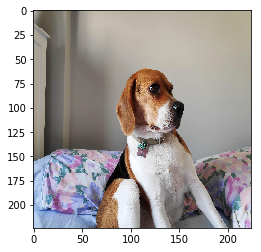

ResNet50 is a model trained on the Imagenet dataset that is able to distinguish between 1000 different labeled objects. ResNet50 is a deep model with 50 layers, you can check it in 3D here.

ResNet50 and decode_predictions have both been imported from tensorflow.keras.applications.resnet50 for you.

It's time to use this trained model to find out Ivy's breed!

- Instantiate a ResNet50 model, setting the weights parameter to be 'imagenet'.
- Use the model to predict on your processed image.
- Decode the first 3 predictions with decode_predictions().

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions
# Instantiate a ResNet50 model with 'imagenet' weights
model = ResNet50(weights='imagenet')

# Predict with ResNet50 on your already processed img
preds = model.predict(img_ready)

# Decode the first 3 predictions
print('Predicted:', decode_predictions(preds, top=3)[0])

### `09: Text prediction with LSTMs`

`During the following exercises you will build a toy LSTM model that is able to predict the next word using a small text dataset. This dataset consist of cleaned quotes from the The Lord of the Ring movies. You can find them in the text variable.

You will turn this text into sequences of length 4 and make use of the Keras Tokenizer to prepare the features and labels for your model!

The Keras Tokenizer is already imported for you to use. It assigns a unique number to each unique word, and stores the mappings in a dictionary. This is important since the model deals with numbers but we later will want to decode the output numbers back into words.


- Split the text into an array of words using `.split()`.
- Make sentences of 4 words each, moving one word at a time.
- Instantiate a `Tokenizer()`, then fit it on the sentences with `.fit_on_texts()`.
- Turn `sentences` into a sequence of numbers calling `.texts_to_sequences()`.

In [18]:
from keras.preprocessing.text import Tokenizer
text = 'it is not the strength of the body but the strength of the spirit it is useless to meet revenge with revenge it will heal nothing even the smallest person can change the course of history all we have to decide is what to do with the time that is given us the burned hand teaches best after that advice about fire goes to the heart'


In [19]:
# Split text into an array of words 
words = text.split()

# Make sentences of 4 words each, moving one word at a time
sentences = []
for i in range(4, len(words)):
  sentences.append(' '.join(words[i-4:i]))

# Instantiate a Tokenizer, then fit it on the sentences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

# Turn sentences into a sequence of numbers
sequences = tokenizer.texts_to_sequences(sentences)
print("Sentences: \n {} \n Sequences: \n {}".format(sentences[:5],sequences[:5]))

Sentences: 
 ['it is not the', 'is not the strength', 'not the strength of', 'the strength of the', 'strength of the body'] 
 Sequences: 
 [[5, 2, 42, 1], [2, 42, 1, 6], [42, 1, 6, 4], [1, 6, 4, 1], [6, 4, 1, 10]]


### `10: Build your LSTM model`
You've already prepared your sequences of text. It's time to build your LSTM model!

Remember your sequences had 4 words each, your model will be trained on the first three words of each sequence, predicting the 4th one. You are going to use an Embedding layer that will essentially learn to turn words into meaningful vectors. These vectors will then be passed to a simple LSTM layer. Our output is a Dense layer with as many neurons as words in the vocabulary and softmax activation. This is because we want to obtain the highest probable next word out of all possible words.

The size of the vocabulary of words (the unique number of words) is stored in vocab_size.


- Import the `Embedding`, `LSTM` and `Dense` layer from `tensorflow.keras` layers.
- Add an `Embedding()` layer of the vocabulary size, that will turn words into 8 number vectors and receive sequences of length 3.
- Add a 32 neuron `LSTM()` layer.
- Add a hidden `Dense()` layer of 32 neurons and an output layer of `vocab_size` neurons with `softmax`.

In [20]:
vocab_size = 44

In [21]:
# Import the Embedding, LSTM and Dense layer
from tensorflow.keras.layers import Embedding, LSTM, Dense

model = Sequential()

# Add an Embedding layer with the right parameters
model.add(Embedding(input_dim = vocab_size, input_length = 3, output_dim = 8, ))

# Add a 32 unit LSTM layer
model.add(LSTM(32))

# Add a hidden Dense layer of 32 units and an output layer of vocab_size with softmax
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 8)              352       
                                                                 
 lstm (LSTM)                 (None, 32)                5248      
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
Total params: 7,712
Trainable params: 7,712
Non-trainable params: 0
_________________________________________________________________


That's a nice looking model you've built! You'll see that this model is powerful enough to learn text relationships, we aren't using a lot of text in this tiny example and our sequences are quite short. This model is to be trained as usual, you would just need to compile it with an optimizer like adam and use crossentropy loss. This is because we have modeled this next word prediction task as a classification problem with all the unique words in our vocabulary as candidate classes.



### `11: Decode your predictions`
Your LSTM model has already been trained (details in the previous exercise success message) so that you don't have to wait. It's time to define a function that decodes its predictions. The trained model will be passed as a default parameter to this function.

Since you are predicting on a model that uses the softmax function, numpy's argmax() can be used to obtain the index/position representing the most probable next word out of the output vector of probabilities.

The tokenizer you previously created and fitted, is loaded for you. You will be making use of its internal index_word dictionary to turn the model's next word prediction (which is an integer) into the actual written word it represents.

You're very close to experimenting with your model!

- Use `texts_to_sequences()` to turn the `test_text` parameter into a sequence of numbers.
- Get the model's next word prediction by passing in `test_seq` . The index/position representing the word with the highest probability is obtained by calling `.argmax(axis=1)[0]` on the numpy array of predictions.
- Return the word that maps to the prediction using the tokenizer's `index_word` dictionary.

In [22]:
def predict_text(test_text, model = model):
  if len(test_text.split()) != 3:
    print('Text input should be 3 words!')
    return False
  
  # Turn the test_text into a sequence of numbers
  test_seq = tokenizer.texts_to_sequences([test_text])
  test_seq = np.array(test_seq)
  
  # Use the model passed as a parameter to predict the next word
  pred = model.predict(test_seq).argmax(axis = 1)[0]
  
  # Return the word that maps to the prediction
  return tokenizer.index_word[pred]

### `12: Test your model!`
The function you just built, predict_text(), is ready to use. Remember that the model object is already passed by default as the second parameter so you just need to provide the function with your 3 word sentences.

Try out these strings on your LSTM model:

- 'meet revenge with'
- 'the course of'
- 'strength of the'

Which sentence could be made with the word output from the sentences above?

- A worthless gnome is King 
- Revenge is your history and sprit ✅
- Take a sword and ride to Florida 

That's right!



In [25]:
print(predict_text('meet revenge with'))
print(predict_text('the course of'))
print(predict_text('strength of the'))


1/1 [==============================] - 0s 22ms/step
body
1/1 [==============================] - 0s 17ms/step
useless
1/1 [==============================] - 0s 18ms/step
useless
